# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 64  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5        # beta of softplus
hidden = 256    # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 118453.578125
iteration 0 loss 99051.6484375


iteration 500 loss 564.865966796875


iteration 1000 loss 480.9093933105469


iteration 1500 loss 425.1582336425781


iteration 2000 loss 392.95733642578125


iteration 2500 loss 373.80780029296875


iteration 3000 loss 359.60284423828125


iteration 3500 loss 346.3220520019531


iteration 4000 loss 332.8693542480469


iteration 4500 loss 319.27020263671875


iteration 5000 loss 305.7405700683594


iteration 5500 loss 292.4302062988281


iteration 6000 loss 279.4153747558594


iteration 6500 loss 266.6367492675781


iteration 7000 loss 254.0500946044922


iteration 7500 loss 241.4676513671875


iteration 8000 loss 228.21707153320312


iteration 8500 loss 212.8991241455078


iteration 9000 loss 191.62387084960938


iteration 9500 loss 157.4136199951172


iteration 10000 loss 110.55107116699219


iteration 10500 loss 69.0989761352539


iteration 11000 loss 39.00471115112305


iteration 11500 loss 24.73714256286621


iteration 12000 loss 15.987824440002441


iteration 12500 loss 31.086750030517578


iteration 13000 loss 9.741889953613281


iteration 13500 loss 8.649598121643066


iteration 14000 loss 7.527192115783691


iteration 14500 loss 6.3810553550720215


iteration 15000 loss 5.239869594573975


iteration 15500 loss 4.158979415893555


iteration 16000 loss 3.5346648693084717


iteration 16500 loss 3.3291046619415283


iteration 17000 loss 3.104768991470337


iteration 17500 loss 2.852452039718628


iteration 18000 loss 2.5740604400634766


iteration 18500 loss 2.275686502456665


iteration 19000 loss 1.9667245149612427


iteration 19500 loss 1.8186688423156738


iteration 20000 loss 1.7435940504074097


iteration 20500 loss 1.662226676940918


iteration 21000 loss 1.5675184726715088


iteration 21500 loss 1.4581652879714966


iteration 22000 loss 1.3345714807510376


iteration 22500 loss 1.1985951662063599


iteration 23000 loss 1.1439248323440552


iteration 23500 loss 1.106131672859192


iteration 24000 loss 1.0668189525604248


iteration 24500 loss 1.0206421613693237


iteration 25000 loss 0.9661697745323181


iteration 25500 loss 0.9028531312942505


iteration 26000 loss 0.8309555649757385


iteration 26500 loss 0.8027979731559753


iteration 27000 loss 0.7779709696769714


iteration 27500 loss 0.7546824216842651


iteration 28000 loss 0.7276711463928223


iteration 28500 loss 0.6955490112304688


iteration 29000 loss 0.6576030850410461


iteration 29500 loss 0.6136595606803894


iteration 30000 loss 0.599528431892395


iteration 30500 loss 0.5816478729248047


iteration 31000 loss 0.5665665864944458


iteration 31500 loss 0.5495434999465942


iteration 32000 loss 0.5292373299598694


iteration 32500 loss 0.5049663186073303


iteration 33000 loss 0.4763265550136566


iteration 33500 loss 0.4637293815612793


iteration 34000 loss 0.4497198164463043


iteration 34500 loss 0.4380434453487396


iteration 35000 loss 0.42460936307907104


iteration 35500 loss 0.40848708152770996


iteration 36000 loss 0.3891856074333191


iteration 36500 loss 0.38753461837768555


iteration 37000 loss 0.37136176228523254


iteration 37500 loss 0.3630237579345703


iteration 38000 loss 0.35486358404159546


iteration 38500 loss 0.3454432487487793


iteration 39000 loss 0.33412685990333557


iteration 39500 loss 0.3206275999546051


iteration 40000 loss 7.216377258300781


iteration 40500 loss 0.30685847997665405


iteration 41000 loss 0.2991821765899658


iteration 41500 loss 0.2926575243473053


iteration 42000 loss 0.28550249338150024


iteration 42500 loss 0.277013897895813


iteration 43000 loss 0.2667872905731201


iteration 43500 loss 2.5108232498168945


iteration 44000 loss 0.25410324335098267


iteration 44500 loss 0.24774354696273804


iteration 45000 loss 0.2416217178106308


iteration 45500 loss 0.2344934195280075


iteration 46000 loss 0.22594362497329712


iteration 46500 loss 0.230026513338089


iteration 47000 loss 0.22037817537784576


iteration 47500 loss 0.21526776254177094


iteration 48000 loss 0.21078242361545563


iteration 48500 loss 0.20588715374469757


iteration 49000 loss 0.20010188221931458


iteration 49500 loss 0.19314031302928925


iteration 50000 loss 0.19611498713493347


iteration 50500 loss 0.1891464740037918


iteration 51000 loss 0.18516847491264343


iteration 51500 loss 0.18156561255455017


iteration 52000 loss 0.17756545543670654


iteration 52500 loss 0.1728239506483078


iteration 53000 loss 0.16704925894737244


iteration 53500 loss 0.171183243393898


iteration 54000 loss 0.16426114737987518


iteration 54500 loss 0.16033582389354706


iteration 55000 loss 0.15696553885936737


iteration 55500 loss 0.15334060788154602


iteration 56000 loss 0.14908874034881592


iteration 56500 loss 0.16478218138217926


iteration 57000 loss 0.1474456638097763


iteration 57500 loss 0.14332689344882965


iteration 58000 loss 0.14039669930934906


iteration 58500 loss 0.13760128617286682


iteration 59000 loss 0.13447359204292297


iteration 59500 loss 0.13084588944911957


iteration 60000 loss 0.15236516296863556


iteration 60500 loss 0.12991906702518463


iteration 61000 loss 0.12643039226531982


iteration 61500 loss 0.12389858067035675


iteration 62000 loss 0.12149123102426529


iteration 62500 loss 0.1188163310289383


iteration 63000 loss 0.11570730805397034


iteration 63500 loss 0.12710492312908173


iteration 64000 loss 0.11444921791553497


iteration 64500 loss 0.11161480098962784


iteration 65000 loss 0.10950900614261627


iteration 65500 loss 0.10742858797311783


iteration 66000 loss 0.10505793243646622


iteration 66500 loss 0.10242431610822678


iteration 67000 loss 0.10717449337244034


iteration 67500 loss 0.10249141603708267


iteration 68000 loss 0.0998605415225029


iteration 68500 loss 0.09782858937978745


iteration 69000 loss 0.0958578810095787


iteration 69500 loss 0.09376377612352371


iteration 70000 loss 0.0910782441496849


iteration 70500 loss 0.09410368651151657


iteration 71000 loss 0.09094130247831345


iteration 71500 loss 0.08899971842765808


iteration 72000 loss 0.08735835552215576


iteration 72500 loss 0.08564691990613937


iteration 73000 loss 0.08373605459928513


iteration 73500 loss 0.12027592211961746


iteration 74000 loss 0.08448526263237


iteration 74500 loss 0.08189768344163895


iteration 75000 loss 0.08015893399715424


iteration 75500 loss 0.07865919917821884


iteration 76000 loss 0.07709949463605881


iteration 76500 loss 0.0753042921423912


iteration 77000 loss 0.08168833702802658


iteration 77500 loss 0.07643900066614151


iteration 78000 loss 0.07414984703063965


iteration 78500 loss 0.07252611964941025


iteration 79000 loss 0.0710921362042427


iteration 79500 loss 0.0695938915014267


iteration 80000 loss 0.06793200224637985


iteration 80500 loss 0.07054854184389114


iteration 81000 loss 0.06763918697834015


iteration 81500 loss 0.06590393930673599


iteration 82000 loss 0.06444792449474335


iteration 82500 loss 0.06293156743049622


iteration 83000 loss 0.06722568720579147


iteration 83500 loss 0.0640653520822525


iteration 84000 loss 0.06223088130354881


iteration 84500 loss 0.06088002771139145


iteration 85000 loss 0.05966676026582718


iteration 85500 loss 0.058432891964912415


iteration 86000 loss 0.06875302642583847


iteration 86500 loss 0.05998764932155609


iteration 87000 loss 0.05793778970837593


iteration 87500 loss 0.05653472617268562


iteration 88000 loss 0.05538399517536163


iteration 88500 loss 0.05426868051290512


iteration 89000 loss 0.05299166217446327


iteration 89500 loss 0.05488084629178047


iteration 90000 loss 0.053028300404548645


iteration 90500 loss 0.051880478858947754


iteration 91000 loss 0.050911203026771545


iteration 91500 loss 0.04990020766854286


iteration 92000 loss 20.644811630249023


iteration 92500 loss 0.05174398049712181


iteration 93000 loss 0.04979543760418892


iteration 93500 loss 0.048518918454647064


iteration 94000 loss 0.04752644896507263


iteration 94500 loss 0.04659683629870415


iteration 95000 loss 0.04569387063384056


iteration 95500 loss 0.04926095902919769


iteration 96000 loss 0.04676177725195885


iteration 96500 loss 0.04529592767357826


iteration 97000 loss 0.04423891380429268


iteration 97500 loss 0.04331516474485397


iteration 98000 loss 0.04236592724919319


iteration 98500 loss 0.045102108269929886


iteration 99000 loss 0.04306790977716446


iteration 99500 loss 0.041886743158102036


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.04102349281311035


iteration 100500 loss 0.040937427431344986


iteration 101000 loss 0.04083124175667763


iteration 101500 loss 0.040695443749427795


iteration 102000 loss 0.040526386350393295


iteration 102500 loss 0.040321532636880875


iteration 103000 loss 0.04007652401924133


iteration 103500 loss 0.039780545979738235


iteration 104000 loss 0.03941361978650093


iteration 104500 loss 0.03896395117044449


iteration 105000 loss 0.038409244269132614


iteration 105500 loss 0.03772407025098801


iteration 106000 loss 0.03940211236476898


iteration 106500 loss 0.036630596965551376


iteration 107000 loss 0.036306943744421005


iteration 107500 loss 0.035906486213207245


iteration 108000 loss 0.03540278971195221


iteration 108500 loss 0.03477076441049576


iteration 109000 loss 0.4362265467643738


iteration 109500 loss 0.03376805782318115


iteration 110000 loss 0.03347015008330345


iteration 110500 loss 0.03310234472155571


iteration 111000 loss 0.03264119103550911


iteration 111500 loss 0.03206172585487366


iteration 112000 loss 0.03179217875003815


iteration 112500 loss 0.0312645323574543


iteration 113000 loss 0.031063811853528023


iteration 113500 loss 0.030826592817902565


iteration 114000 loss 0.03052482008934021


iteration 114500 loss 0.03014465793967247


iteration 115000 loss 0.02966618351638317


iteration 115500 loss 0.029065832495689392


iteration 116000 loss 0.028819890692830086


iteration 116500 loss 0.028616774827241898


iteration 117000 loss 0.028407897800207138


iteration 117500 loss 0.028147293254733086


iteration 118000 loss 0.027816424146294594


iteration 118500 loss 0.027401277795433998


iteration 119000 loss 0.026879863813519478


iteration 119500 loss 0.02660001814365387


iteration 120000 loss 0.026395058259367943


iteration 120500 loss 0.0262228362262249


iteration 121000 loss 0.026013793423771858


iteration 121500 loss 0.025748247280716896


iteration 122000 loss 0.025412917137145996


iteration 122500 loss 0.024992281571030617


iteration 123000 loss 0.03229031711816788


iteration 123500 loss 0.024340011179447174


iteration 124000 loss 0.024137139320373535


iteration 124500 loss 0.023889364674687386


iteration 125000 loss 0.023576602339744568


iteration 125500 loss 0.02318538725376129


iteration 126000 loss 0.023350203409790993


iteration 126500 loss 0.022619400173425674


iteration 127000 loss 0.022437630221247673


iteration 127500 loss 0.022219466045498848


iteration 128000 loss 0.02194279059767723


iteration 128500 loss 0.02159622125327587


iteration 129000 loss 0.021174587309360504


iteration 129500 loss 0.02108149603009224


iteration 130000 loss 0.02093248814344406


iteration 130500 loss 0.020768512040376663


iteration 131000 loss 0.02056456170976162


iteration 131500 loss 0.02030506543815136


iteration 132000 loss 0.01997997984290123


iteration 132500 loss 0.021484090015292168


iteration 133000 loss 0.01955147087574005


iteration 133500 loss 0.019422970712184906


iteration 134000 loss 0.019282273948192596


iteration 134500 loss 0.019108392298221588


iteration 135000 loss 0.018887432292103767


iteration 135500 loss 0.018608953803777695


iteration 136000 loss 0.018259957432746887


iteration 136500 loss 0.01816660724580288


iteration 137000 loss 0.01804913580417633


iteration 137500 loss 0.017924077808856964


iteration 138000 loss 0.01776973158121109


iteration 138500 loss 0.01757470704615116


iteration 139000 loss 0.01732715405523777


iteration 139500 loss 0.01701734960079193


iteration 140000 loss 0.016915304586291313


iteration 140500 loss 0.016794754192233086


iteration 141000 loss 0.016684560105204582


iteration 141500 loss 0.016552191227674484


iteration 142000 loss 0.016386667266488075


iteration 142500 loss 0.01617625541985035


iteration 143000 loss 0.015911765396595


iteration 143500 loss 0.015814123675227165


iteration 144000 loss 0.015645865350961685


iteration 144500 loss 0.01554704736918211


iteration 145000 loss 0.015436231158673763


iteration 145500 loss 0.015299764461815357


iteration 146000 loss 0.015127956867218018


iteration 146500 loss 0.014910968020558357


iteration 147000 loss 0.014636465348303318


iteration 147500 loss 0.014592544175684452


iteration 148000 loss 0.014496111311018467


iteration 148500 loss 0.01439860463142395


iteration 149000 loss 0.014280724339187145


iteration 149500 loss 0.014133213087916374


iteration 150000 loss 0.013946003280580044


iteration 150500 loss 0.013710001483559608


iteration 151000 loss 0.013648421503603458


iteration 151500 loss 0.013534936122596264


iteration 152000 loss 0.013444791547954082


iteration 152500 loss 0.013340156525373459


iteration 153000 loss 0.013210526667535305


iteration 153500 loss 0.013047154061496258


iteration 154000 loss 0.012840849347412586


iteration 154500 loss 0.012763306498527527


iteration 155000 loss 0.012631505727767944


iteration 155500 loss 0.012535500340163708


iteration 156000 loss 0.01242328155785799


iteration 156500 loss 0.012283839285373688


iteration 157000 loss 0.012107731774449348


iteration 157500 loss 0.012254096567630768


iteration 158000 loss 0.011896382085978985


iteration 158500 loss 0.0118205351755023


iteration 159000 loss 0.011740317568182945


iteration 159500 loss 0.011643694713711739


iteration 160000 loss 0.011523108929395676


iteration 160500 loss 0.011371079832315445


iteration 161000 loss 0.011182332411408424


iteration 161500 loss 0.011148682795464993


iteration 162000 loss 0.011065635830163956


iteration 162500 loss 0.010994532145559788


iteration 163000 loss 0.010911178775131702


iteration 163500 loss 0.01080832164734602


iteration 164000 loss 0.010679640807211399


iteration 164500 loss 0.01051933690905571


iteration 165000 loss 0.010485785081982613


iteration 165500 loss 0.010373620316386223


iteration 166000 loss 0.010303287766873837


iteration 166500 loss 0.010224636644124985


iteration 167000 loss 0.01012873649597168


iteration 167500 loss 0.010009371675550938


iteration 168000 loss 0.009857410565018654


iteration 168500 loss 0.00980214774608612


iteration 169000 loss 0.009698737412691116


iteration 169500 loss 0.009623642079532146


iteration 170000 loss 0.009536167606711388


iteration 170500 loss 0.009427500888705254


iteration 171000 loss 0.009291580878198147


iteration 171500 loss 0.00926896184682846


iteration 172000 loss 0.009147909469902515


iteration 172500 loss 0.009078780189156532


iteration 173000 loss 0.009002108126878738


iteration 173500 loss 0.00890837237238884


iteration 174000 loss 0.008791047148406506


iteration 174500 loss 0.047102294862270355


iteration 175000 loss 0.008651026524603367


iteration 175500 loss 0.008589878678321838


iteration 176000 loss 0.008534828200936317


iteration 176500 loss 0.008469581604003906


iteration 177000 loss 0.008389492519199848


iteration 177500 loss 0.00828986894339323


iteration 178000 loss 0.008164039812982082


iteration 178500 loss 0.00812999065965414


iteration 179000 loss 0.008061781525611877


iteration 179500 loss 0.00800376757979393


iteration 180000 loss 0.007934993132948875


iteration 180500 loss 0.007850049994885921


iteration 181000 loss 0.007743626367300749


iteration 181500 loss 0.007767402566969395


iteration 182000 loss 0.007637908682227135


iteration 182500 loss 0.00758391572162509


iteration 183000 loss 0.007529378402978182


iteration 183500 loss 0.007464224006980658


iteration 184000 loss 0.007383870426565409


iteration 184500 loss 0.007284036837518215


iteration 185000 loss 0.007309033069759607


iteration 185500 loss 0.007193121127784252


iteration 186000 loss 0.007144155912101269


iteration 186500 loss 0.007095622830092907


iteration 187000 loss 0.00703737186267972


iteration 187500 loss 0.00696594687178731


iteration 188000 loss 0.006876739207655191


iteration 188500 loss 0.007016110233962536


iteration 189000 loss 0.006773387081921101


iteration 189500 loss 0.00672859326004982


iteration 190000 loss 0.006685358937829733


iteration 190500 loss 0.00663274060934782


iteration 191000 loss 0.006567782256752253


iteration 191500 loss 0.006487223785370588


iteration 192000 loss 0.025142662227153778


iteration 192500 loss 0.006388187408447266


iteration 193000 loss 0.006333664059638977


iteration 193500 loss 0.0062838210724294186


iteration 194000 loss 0.006225019693374634


iteration 194500 loss 0.006153041962534189


iteration 195000 loss 0.006065377499908209


iteration 195500 loss 0.0060652755200862885


iteration 196000 loss 0.006003169342875481


iteration 196500 loss 0.005957816727459431


iteration 197000 loss 0.005905982106924057


iteration 197500 loss 0.00584301445633173


iteration 198000 loss 0.005764841102063656


iteration 198500 loss 0.005762557964771986


iteration 199000 loss 0.00568823516368866


iteration 199500 loss 0.005645609926432371


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.005597640760242939


iteration 200500 loss 0.0055926027707755566


iteration 201000 loss 0.00558597082272172


iteration 201500 loss 0.005577261094003916


iteration 202000 loss 0.005565887317061424


iteration 202500 loss 0.005550766829401255


iteration 203000 loss 0.005531638395041227


iteration 203500 loss 0.005507083144038916


iteration 204000 loss 0.005474258214235306


iteration 204500 loss 0.005431635305285454


iteration 205000 loss 0.005378169938921928


iteration 205500 loss 0.005311585962772369


iteration 206000 loss 0.005775371566414833


iteration 206500 loss 0.0052167074754834175


iteration 207000 loss 0.0051962835714221


iteration 207500 loss 0.005169514566659927


iteration 208000 loss 0.0051338705234229565


iteration 208500 loss 0.005088321398943663


iteration 209000 loss 0.0050316499546170235


iteration 209500 loss 0.004960774444043636


iteration 210000 loss 0.004917755722999573


iteration 210500 loss 0.004898698069155216


iteration 211000 loss 0.004873950965702534


iteration 211500 loss 0.004840785637497902


iteration 212000 loss 0.004798248875886202


iteration 212500 loss 0.004745188169181347


iteration 213000 loss 0.004678965546190739


iteration 213500 loss 0.004640402738004923


iteration 214000 loss 0.004615108948200941


iteration 214500 loss 0.004581456072628498


iteration 215000 loss 0.00453838100656867


iteration 215500 loss 0.004484845791012049


iteration 216000 loss 0.004418009892106056


iteration 216500 loss 0.004402089398354292


iteration 217000 loss 0.004384172614663839


iteration 217500 loss 0.00436079315841198


iteration 218000 loss 0.004329513292759657


iteration 218500 loss 0.004289458971470594


iteration 219000 loss 0.004239531233906746


iteration 219500 loss 0.004177312832325697


iteration 220000 loss 0.004159974865615368


iteration 220500 loss 0.004144180100411177


iteration 221000 loss 0.004123940598219633


iteration 221500 loss 0.004096871241927147


iteration 222000 loss 0.004061679821461439


iteration 222500 loss 0.004017473664134741


iteration 223000 loss 0.0039625042118132114


iteration 223500 loss 0.00393304880708456


iteration 224000 loss 0.00391955254599452


iteration 224500 loss 0.0039024511352181435


iteration 225000 loss 0.003880028845742345


iteration 225500 loss 0.0038502425886690617


iteration 226000 loss 0.0038122234400361776


iteration 226500 loss 0.00376494275406003


iteration 227000 loss 0.003719957312569022


iteration 227500 loss 0.0037063085474073887


iteration 228000 loss 0.003690222045406699


iteration 228500 loss 0.0036692603025585413


iteration 229000 loss 0.0036413436755537987


iteration 229500 loss 0.003605527337640524


iteration 230000 loss 0.003561006160452962


iteration 230500 loss 0.003517789300531149


iteration 231000 loss 0.003501989645883441


iteration 231500 loss 0.0034823312889784575


iteration 232000 loss 0.0034560789354145527


iteration 232500 loss 0.0034222151152789593


iteration 233000 loss 0.003380029695108533


iteration 233500 loss 0.003340776078402996


iteration 234000 loss 0.0033298300113528967


iteration 234500 loss 0.0033170836977660656


iteration 235000 loss 0.003300837939605117


iteration 235500 loss 0.0032792282290756702


iteration 236000 loss 0.0032508147414773703


iteration 236500 loss 0.003214804455637932


iteration 237000 loss 0.0031701887492090464


iteration 237500 loss 0.0031541017815470695


iteration 238000 loss 0.003143338020890951


iteration 238500 loss 0.0031296233646571636


iteration 239000 loss 0.0031120104249566793


iteration 239500 loss 0.0030883175786584616


iteration 240000 loss 0.003057848196476698


iteration 240500 loss 0.003019732888787985


iteration 241000 loss 0.002987926360219717


iteration 241500 loss 0.0029778846073895693


iteration 242000 loss 0.0029656202532351017


iteration 242500 loss 0.002950043883174658


iteration 243000 loss 0.0029292493127286434


iteration 243500 loss 0.002902053529396653


iteration 244000 loss 0.002867727307602763


iteration 244500 loss 0.002844025380909443


iteration 245000 loss 0.0028223285917192698


iteration 245500 loss 0.002812068210914731


iteration 246000 loss 0.0027990180533379316


iteration 246500 loss 0.0027820675168186426


iteration 247000 loss 0.0027594163548201323


iteration 247500 loss 0.002730319509282708


iteration 248000 loss 0.002694066846743226


iteration 248500 loss 0.0026729945093393326


iteration 249000 loss 0.0026605266612023115


iteration 249500 loss 0.002644556574523449


iteration 250000 loss 0.0026231687515974045


iteration 250500 loss 0.0025955208111554384


iteration 251000 loss 0.002561011118814349


iteration 251500 loss 0.0025439353194087744


iteration 252000 loss 0.002535817911848426


iteration 252500 loss 0.0025254245847463608


iteration 253000 loss 0.002512147184461355


iteration 253500 loss 0.002494664629921317


iteration 254000 loss 0.0024715433828532696


iteration 254500 loss 0.0024421908892691135


iteration 255000 loss 0.0024142905604094267


iteration 255500 loss 0.0024061084259301424


iteration 256000 loss 0.002397577976807952


iteration 256500 loss 0.002386651234701276


iteration 257000 loss 0.0023726888466626406


iteration 257500 loss 0.0023540135007351637


iteration 258000 loss 0.00232968432828784


iteration 258500 loss 0.002299167448654771


iteration 259000 loss 0.002282900270074606


iteration 259500 loss 0.002275626640766859


iteration 260000 loss 0.002266226103529334


iteration 260500 loss 0.0022542120423167944


iteration 261000 loss 0.0022385476622730494


iteration 261500 loss 0.0022176760248839855


iteration 262000 loss 0.002191094448789954


iteration 262500 loss 0.0021666623651981354


iteration 263000 loss 0.0021580932661890984


iteration 263500 loss 0.0021478254348039627


iteration 264000 loss 0.002134681213647127


iteration 264500 loss 0.0021170980762690306


iteration 265000 loss 0.0020941966213285923


iteration 265500 loss 0.0020654741674661636


iteration 266000 loss 0.002056518103927374


iteration 266500 loss 0.002048863098025322


iteration 267000 loss 0.0020390308927744627


iteration 267500 loss 0.002026510192081332


iteration 268000 loss 0.002009698422625661


iteration 268500 loss 0.0019879131577908993


iteration 269000 loss 0.001960484543815255


iteration 269500 loss 0.0019531298894435167


iteration 270000 loss 0.0019460932817310095


iteration 270500 loss 0.0019370586378499866


iteration 271000 loss 0.0019255366642028093


iteration 271500 loss 0.0019102408550679684


iteration 272000 loss 0.0018901650328189135


iteration 272500 loss 0.0018647357355803251


iteration 273000 loss 0.0018560737371444702


iteration 273500 loss 0.0018503379542380571


iteration 274000 loss 0.001842719386331737


iteration 274500 loss 0.001833070651628077


iteration 275000 loss 0.0018206443637609482


iteration 275500 loss 0.0018039302667602897


iteration 276000 loss 0.0017824447713792324


iteration 276500 loss 0.0017648562788963318


iteration 277000 loss 0.001759118284098804


iteration 277500 loss 0.0017525573493912816


iteration 278000 loss 0.001744112349115312


iteration 278500 loss 0.0017333668656647205


iteration 279000 loss 0.0017190875951200724


iteration 279500 loss 0.0017003585817292333


iteration 280000 loss 0.0028056141454726458


iteration 280500 loss 0.001672081765718758


iteration 281000 loss 0.0016652257181704044


iteration 281500 loss 0.001656486070714891


iteration 282000 loss 0.0016453505959361792


iteration 282500 loss 0.0016303727170452476


iteration 283000 loss 0.0016109792049974203


iteration 283500 loss 0.0015951928216964006


iteration 284000 loss 0.001588709419593215


iteration 284500 loss 0.0015808072639629245


iteration 285000 loss 0.0015707588754594326


iteration 285500 loss 0.0015574523713439703


iteration 286000 loss 0.0015399480471387506


iteration 286500 loss 0.0015242374502122402


iteration 287000 loss 0.0015178811736404896


iteration 287500 loss 0.0015125613426789641


iteration 288000 loss 0.0015055157709866762


iteration 288500 loss 0.0014965840382501483


iteration 289000 loss 0.0014849556609988213


iteration 289500 loss 0.0014693854609504342


iteration 290000 loss 0.0014495820505544543


iteration 290500 loss 0.0014452924951910973


iteration 291000 loss 0.0014406992122530937


iteration 291500 loss 0.0014345510862767696


iteration 292000 loss 0.0014266928192228079


iteration 292500 loss 0.0014166455948725343


iteration 293000 loss 0.0014031751779839396


iteration 293500 loss 0.0013857551384717226


iteration 294000 loss 0.0013765168841928244


iteration 294500 loss 0.001372433383949101


iteration 295000 loss 0.0013672858476638794


iteration 295500 loss 0.0013605436543002725


iteration 296000 loss 0.0013519404456019402


iteration 296500 loss 0.0013406820362433791


iteration 297000 loss 0.0013256993843242526


iteration 297500 loss 0.0013126834528520703


iteration 298000 loss 0.0013080476783216


iteration 298500 loss 0.0013038850156590343


iteration 299000 loss 0.0012983024353161454


iteration 299500 loss 0.0012911484809592366


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.001282007317058742


iteration 300500 loss 0.0012810779735445976


iteration 301000 loss 0.0012798362877219915


iteration 301500 loss 0.0012781939003616571


iteration 302000 loss 0.001275989692658186


iteration 302500 loss 0.0012731385650113225


iteration 303000 loss 0.001269394881092012


iteration 303500 loss 0.0012643797090277076


iteration 304000 loss 0.0012578116729855537


iteration 304500 loss 0.0012494532857090235


iteration 305000 loss 0.0012384047731757164


iteration 305500 loss 0.0012240747455507517


iteration 306000 loss 0.0012096737045794725


iteration 306500 loss 0.0012027978664264083


iteration 307000 loss 0.0011940737022086978


iteration 307500 loss 0.0011824879329651594


iteration 308000 loss 0.0011676741996780038


iteration 308500 loss 0.0011579591082409024


iteration 309000 loss 0.0011499590473249555


iteration 309500 loss 0.0011395364999771118


iteration 310000 loss 0.0011258585145696998


iteration 310500 loss 0.0011153266532346606


iteration 311000 loss 0.001107202610000968


iteration 311500 loss 0.0010965035762637854


iteration 312000 loss 0.0010826830985024571


iteration 312500 loss 0.0010750774526968598


iteration 313000 loss 0.0010689644841477275


iteration 313500 loss 0.0010612133191898465


iteration 314000 loss 0.001051075174473226


iteration 314500 loss 0.00103797297924757


iteration 315000 loss 0.0010305163450539112


iteration 315500 loss 0.0010247903410345316


iteration 316000 loss 0.0010174809722229838


iteration 316500 loss 0.001007965300232172


iteration 317000 loss 0.0009956011781468987


iteration 317500 loss 0.0009877609554678202


iteration 318000 loss 0.000981594086624682


iteration 318500 loss 0.0009737759246490896


iteration 319000 loss 0.0009633873705752194


iteration 319500 loss 0.0009515704587101936


iteration 320000 loss 0.0009474616963416338


iteration 320500 loss 0.0009420300484634936


iteration 321000 loss 0.0009351301123388112


iteration 321500 loss 0.0009261201485060155


iteration 322000 loss 0.0009145565563812852


iteration 322500 loss 0.0009079757728613913


iteration 323000 loss 0.0009032521047629416


iteration 323500 loss 0.0008971822680905461


iteration 324000 loss 0.0008894127677194774


iteration 324500 loss 0.0008791637956164777


iteration 325000 loss 0.0008701552869752049


iteration 325500 loss 0.0008647539070807397


iteration 326000 loss 0.0008578897104598582


iteration 326500 loss 0.000848835043143481


iteration 327000 loss 0.0008385038236156106


iteration 327500 loss 0.0008334640297107399


iteration 328000 loss 0.0008270491380244493


iteration 328500 loss 0.0008186599588952959


iteration 329000 loss 0.0008094314252957702


iteration 329500 loss 0.0008051756885834038


iteration 330000 loss 0.0008009055745787919


iteration 330500 loss 0.0007953636813908815


iteration 331000 loss 0.0007882930804044008


iteration 331500 loss 0.0007790203089825809


iteration 332000 loss 0.0007721532601863146


iteration 332500 loss 0.0007675912929698825


iteration 333000 loss 0.000761757546570152


iteration 333500 loss 0.0007542272214777768


iteration 334000 loss 0.0007446239469572902


iteration 334500 loss 0.0007415427244268358


iteration 335000 loss 0.0007380042807199061


iteration 335500 loss 0.0007333226385526359


iteration 336000 loss 0.000727370847016573


iteration 336500 loss 0.0007196045480668545


iteration 337000 loss 0.0007114670588634908


iteration 337500 loss 0.0007087715202942491


iteration 338000 loss 0.0007051603170111775


iteration 338500 loss 0.0007004395592957735


iteration 339000 loss 0.0006944139022380114


iteration 339500 loss 0.0006865488830953836


iteration 340000 loss 0.0006802082643844187


iteration 340500 loss 0.000677294738125056


iteration 341000 loss 0.0006733093759976327


iteration 341500 loss 0.0006682188832201064


iteration 342000 loss 0.0006616727914661169


iteration 342500 loss 0.0006533347768709064


iteration 343000 loss 0.0006507313810288906


iteration 343500 loss 0.000647905224468559


iteration 344000 loss 0.0006440563593059778


iteration 344500 loss 0.0006391835049726069


iteration 345000 loss 0.0006328464951366186


iteration 345500 loss 0.0006255540065467358


iteration 346000 loss 0.0006227085250429809


iteration 346500 loss 0.0006197731127031147


iteration 347000 loss 0.0006158205796964467


iteration 347500 loss 0.0006107734516263008


iteration 348000 loss 0.0006042486638762057


iteration 348500 loss 0.0005986209725961089


iteration 349000 loss 0.0005962344002909958


iteration 349500 loss 0.0005930184270255268


iteration 350000 loss 0.0005887949955649674


iteration 350500 loss 0.0005833967006765306


iteration 351000 loss 0.0005764295347034931


iteration 351500 loss 0.0005731535493396223


iteration 352000 loss 0.0005705523071810603


iteration 352500 loss 0.0005669694510288537


iteration 353000 loss 0.0005624000914394855


iteration 353500 loss 0.0005565078463405371


iteration 354000 loss 0.0005508806789293885


iteration 354500 loss 0.0005490417825058103


iteration 355000 loss 0.0005466228467412293


iteration 355500 loss 0.0005433529731817544


iteration 356000 loss 0.0005391180166043341


iteration 356500 loss 0.0005337047623470426


iteration 357000 loss 0.0005281497142277658


iteration 357500 loss 0.0005256299045868218


iteration 358000 loss 0.0005221763858571649


iteration 358500 loss 0.0005177516723051667


iteration 359000 loss 0.000512022408656776


iteration 359500 loss 0.0005081799463368952


iteration 360000 loss 0.0005054905195720494


iteration 360500 loss 0.000501889968290925


iteration 361000 loss 0.0004972749156877398


iteration 361500 loss 0.0005546826287172735


iteration 362000 loss 0.0004897296894341707


iteration 362500 loss 0.0004876840393990278


iteration 363000 loss 0.0004849204851780087


iteration 363500 loss 0.00048126891488209367


iteration 364000 loss 0.00047659807023592293


iteration 364500 loss 0.00047138871741481125


iteration 365000 loss 0.0004694681556429714


iteration 365500 loss 0.00046689045848324895


iteration 366000 loss 0.00046343772555701435


iteration 366500 loss 0.00045900754048489034


iteration 367000 loss 0.00045384306577034295


iteration 367500 loss 0.0004521837108768523


iteration 368000 loss 0.0004499973147176206


iteration 368500 loss 0.0004469781706575304


iteration 369000 loss 0.00044309633085504174


iteration 369500 loss 0.00043812961666844785


iteration 370000 loss 0.00043552773422561586


iteration 370500 loss 0.0004339232691563666


iteration 371000 loss 0.00043179758358746767


iteration 371500 loss 0.0004288549826014787


iteration 372000 loss 0.00042509994818829


iteration 372500 loss 0.000420303491409868


iteration 373000 loss 0.0004183290293440223


iteration 373500 loss 0.0004168510786257684


iteration 374000 loss 0.00041491174488328397


iteration 374500 loss 0.00041221926221624017


iteration 375000 loss 0.00040875133709050715


iteration 375500 loss 0.00040430095396004617


iteration 376000 loss 0.00040195422479882836


iteration 376500 loss 0.0004005713271908462


iteration 377000 loss 0.0003987447125837207


iteration 377500 loss 0.0003962449845857918


iteration 378000 loss 0.0003929616941604763


iteration 378500 loss 0.0003887660277541727


iteration 379000 loss 0.00038601658889092505


iteration 379500 loss 0.00038439728086814284


iteration 380000 loss 0.00038218917325139046


iteration 380500 loss 0.00037921208422631025


iteration 381000 loss 0.00037538574542850256


iteration 381500 loss 0.00037215749034658074


iteration 382000 loss 0.00037086085649207234


iteration 382500 loss 0.0003691453021019697


iteration 383000 loss 0.00036680541234090924


iteration 383500 loss 0.00036371496389620006


iteration 384000 loss 0.00035975940409116447


iteration 384500 loss 0.00035789358662441373


iteration 385000 loss 0.0003567781241144985


iteration 385500 loss 0.00035532296169549227


iteration 386000 loss 0.0003533673589117825


iteration 386500 loss 0.0003506793291307986


iteration 387000 loss 0.0003472281387075782


iteration 387500 loss 0.00034395221155136824


iteration 388000 loss 0.00034244335256516933


iteration 388500 loss 0.00034039304591715336


iteration 389000 loss 0.0003376073145773262


iteration 389500 loss 0.000334027485223487


iteration 390000 loss 0.000331675197230652


iteration 390500 loss 0.000330111215589568


iteration 391000 loss 0.000327953661326319


iteration 391500 loss 0.0003250915906392038


iteration 392000 loss 0.0003214425523765385


iteration 392500 loss 0.00031993704033084214


iteration 393000 loss 0.0003184983506798744


iteration 393500 loss 0.0003165275848004967


iteration 394000 loss 0.0003138542815577239


iteration 394500 loss 0.00031044200295582414


iteration 395000 loss 0.00030869795591570437


iteration 395500 loss 0.00030760368099436164


iteration 396000 loss 0.0003061816969420761


iteration 396500 loss 0.0003042109892703593


iteration 397000 loss 0.0003015619586221874


iteration 397500 loss 0.000298200553515926


iteration 398000 loss 0.00029698386788368225


iteration 398500 loss 0.0002959206758532673


iteration 399000 loss 0.00029449310386553407


iteration 399500 loss 0.00029251904925331473


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.00028989833663217723


iteration 400500 loss 0.0002896703372243792


iteration 401000 loss 0.0002893540950026363


iteration 401500 loss 0.0002889453899115324


iteration 402000 loss 0.00028839512378908694


iteration 402500 loss 0.00028769459458999336


iteration 403000 loss 0.0002868082083296031


iteration 403500 loss 0.0002856961218640208


iteration 404000 loss 0.00028431371902115643


iteration 404500 loss 0.00028266487061046064


iteration 405000 loss 0.0002808214630931616


iteration 405500 loss 0.00027897919062525034


iteration 406000 loss 0.0002771408180706203


iteration 406500 loss 0.00027531481464393437


iteration 407000 loss 0.00027350871823728085


iteration 407500 loss 0.0002717187162488699


iteration 408000 loss 0.0002699336037039757


iteration 408500 loss 0.0002681714831851423


iteration 409000 loss 0.0002664309286046773


iteration 409500 loss 0.00026468565920367837


iteration 410000 loss 0.0002629624505061656


iteration 410500 loss 0.000261259323451668


iteration 411000 loss 0.0002595599216874689


iteration 411500 loss 0.00025787303457036614


iteration 412000 loss 0.00025622089742682874


iteration 412500 loss 0.0002545552561059594


iteration 413000 loss 0.00025291251949965954


iteration 413500 loss 0.00025128069682978094


iteration 414000 loss 0.0002496647648513317


iteration 414500 loss 0.00024806399596855044


iteration 415000 loss 0.00024646485690027475


iteration 415500 loss 0.0002448800078127533


iteration 416000 loss 0.0002433090121485293


iteration 416500 loss 0.00024175473663490266


iteration 417000 loss 0.00024019913689699024


iteration 417500 loss 0.00023867272830102593


iteration 418000 loss 0.00023713674454484135


iteration 418500 loss 0.00023561732086818665


iteration 419000 loss 0.00023411306028719991


iteration 419500 loss 0.0002326166577404365


iteration 420000 loss 0.00023112425697036088


iteration 420500 loss 0.00022965723474044353


iteration 421000 loss 0.00022818312572780997


iteration 421500 loss 0.00022672054183203727


iteration 422000 loss 0.00022527169494424015


iteration 422500 loss 0.00022383192845154554


iteration 423000 loss 0.00022241209808271378


iteration 423500 loss 0.00022098870249465108


iteration 424000 loss 0.00021957272838335484


iteration 424500 loss 0.00021817313972860575


iteration 425000 loss 0.00021677326003555208


iteration 425500 loss 0.00021539539739023894


iteration 426000 loss 0.00021402043057605624


iteration 426500 loss 0.00021265725081320852


iteration 427000 loss 0.00021128835214767605


iteration 427500 loss 0.0002099357807310298


iteration 428000 loss 0.00020859736832790077


iteration 428500 loss 0.00020726615912280977


iteration 429000 loss 0.00020594611123669893


iteration 429500 loss 0.0002046164736384526


iteration 430000 loss 0.00020332011627033353


iteration 430500 loss 0.00020201082224957645


iteration 431000 loss 0.00020071330072823912


iteration 431500 loss 0.00019942734797950834


iteration 432000 loss 0.0001981530076591298


iteration 432500 loss 0.00019688429892994463


iteration 433000 loss 0.00019562788656912744


iteration 433500 loss 0.000194370120880194


iteration 434000 loss 0.00019312402582727373


iteration 434500 loss 0.00019188327132724226


iteration 435000 loss 0.00019065229571424425


iteration 435500 loss 0.00018943805480375886


iteration 436000 loss 0.00018822452693711966


iteration 436500 loss 0.00018701348744798452


iteration 437000 loss 0.00018580254982225597


iteration 437500 loss 0.0001846168888732791


iteration 438000 loss 0.00018342900148127228


iteration 438500 loss 0.0001822503108996898


iteration 439000 loss 0.0001810815738281235


iteration 439500 loss 0.0001799168239813298


iteration 440000 loss 0.0001787576184142381


iteration 440500 loss 0.00017760701302904636


iteration 441000 loss 0.00017646582273300737


iteration 441500 loss 0.0001753272517817095


iteration 442000 loss 0.00017420125368516892


iteration 442500 loss 0.00017308237147517502


iteration 443000 loss 0.00017196145199704915


iteration 443500 loss 0.00017085351282730699


iteration 444000 loss 0.0001697579282335937


iteration 444500 loss 0.00016864902863744646


iteration 445000 loss 0.00016757306002546102


iteration 445500 loss 0.0001664795563556254


iteration 446000 loss 0.00016540485376026481


iteration 446500 loss 0.00016433522978331894


iteration 447000 loss 0.00016327612684108317


iteration 447500 loss 0.00016221879923250526


iteration 448000 loss 0.00016116767073981464


iteration 448500 loss 0.00016012739797588438


iteration 449000 loss 0.00015908913337625563


iteration 449500 loss 0.00015804720169398934


iteration 450000 loss 0.00015703178360126913


iteration 450500 loss 0.0001560137898195535


iteration 451000 loss 0.00015499415167141706


iteration 451500 loss 0.0001539909717394039


iteration 452000 loss 0.00015299471851903945


iteration 452500 loss 0.00015199296467471868


iteration 453000 loss 0.00015099937445484102


iteration 453500 loss 0.0001500283251516521


iteration 454000 loss 0.00014904106501489878


iteration 454500 loss 0.00014808113337494433


iteration 455000 loss 0.0001471204886911437


iteration 455500 loss 0.0001461601204937324


iteration 456000 loss 0.00014520963304676116


iteration 456500 loss 0.0001442577049601823


iteration 457000 loss 0.0001433193392585963


iteration 457500 loss 0.00014238100266084075


iteration 458000 loss 0.00014145634486339986


iteration 458500 loss 0.00014053573249839246


iteration 459000 loss 0.00013961367949377745


iteration 459500 loss 0.00013869850954506546


iteration 460000 loss 0.00013779861910734326


iteration 460500 loss 0.0001368970115436241


iteration 461000 loss 0.00013600857346318662


iteration 461500 loss 0.0001351120154140517


iteration 462000 loss 0.00013422932534012944


iteration 462500 loss 0.00013335011317394674


iteration 463000 loss 0.00013248223694972694


iteration 463500 loss 0.00013161385140847415


iteration 464000 loss 0.0001307516504311934


iteration 464500 loss 0.00012989035167265683


iteration 465000 loss 0.00012904510367661715


iteration 465500 loss 0.00012819335097447038


iteration 466000 loss 0.00012736335338559002


iteration 466500 loss 0.00012652220902964473


iteration 467000 loss 0.00012568733654916286


iteration 467500 loss 0.00012485802290029824


iteration 468000 loss 0.00012404064182192087


iteration 468500 loss 0.00012322832481004298


iteration 469000 loss 0.00012241132208146155


iteration 469500 loss 0.00012161812628619373


iteration 470000 loss 0.00012081136082997546


iteration 470500 loss 0.00012001866707578301


iteration 471000 loss 0.00011922697740374133


iteration 471500 loss 0.00011843952961498871


iteration 472000 loss 0.00011765905219363049


iteration 472500 loss 0.0001168853705166839


iteration 473000 loss 0.0001161183463409543


iteration 473500 loss 0.00011534754594322294


iteration 474000 loss 0.00011459028610261157


iteration 474500 loss 0.00011382865341147408


iteration 475000 loss 0.00011307871318422258


iteration 475500 loss 0.00011233248369535431


iteration 476000 loss 0.00011159100540680811


iteration 476500 loss 0.00011085929872933775


iteration 477000 loss 0.00011011998140020296


iteration 477500 loss 0.00010939465573756024


iteration 478000 loss 0.00010866834782063961


iteration 478500 loss 0.00010794329136842862


iteration 479000 loss 0.00010723589366534725


iteration 479500 loss 0.00010652915807440877


iteration 480000 loss 0.00010581628885120153


iteration 480500 loss 0.0001051153740263544


iteration 481000 loss 0.00010442279017297551


iteration 481500 loss 0.00010373086843173951


iteration 482000 loss 0.00010305096657248214


iteration 482500 loss 0.00010236086382064968


iteration 483000 loss 0.0001016781316138804


iteration 483500 loss 0.00010101281077368185


iteration 484000 loss 0.00010033858416136354


iteration 484500 loss 9.967396181309596e-05


iteration 485000 loss 9.901232260745019e-05


iteration 485500 loss 9.835531818680465e-05


iteration 486000 loss 9.769909229362383e-05


iteration 486500 loss 9.705715638119727e-05


iteration 487000 loss 9.640530333854258e-05


iteration 487500 loss 9.576918819220737e-05


iteration 488000 loss 9.512893302598968e-05


iteration 488500 loss 9.449892968405038e-05


iteration 489000 loss 9.386854799231514e-05


iteration 489500 loss 9.324635175289586e-05


iteration 490000 loss 9.262189269065857e-05


iteration 490500 loss 9.200185013469309e-05


iteration 491000 loss 9.139269241131842e-05


iteration 491500 loss 9.078638686332852e-05


iteration 492000 loss 9.018334822030738e-05


iteration 492500 loss 8.958173566497862e-05


iteration 493000 loss 8.898427040548995e-05


iteration 493500 loss 8.83906614035368e-05


iteration 494000 loss 8.78023129189387e-05


iteration 494500 loss 8.720882760826498e-05


iteration 495000 loss 8.663525659358129e-05


iteration 495500 loss 8.605458424426615e-05


iteration 496000 loss 8.548183541279286e-05


iteration 496500 loss 8.490945037920028e-05


iteration 497000 loss 8.434654591837898e-05


iteration 497500 loss 8.37879124446772e-05


iteration 498000 loss 8.321781933773309e-05


iteration 498500 loss 8.266709482995793e-05


iteration 499000 loss 8.210502710426226e-05


iteration 499500 loss 8.156021795002744e-05


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss 4.379215717315674


loss -84.69391632080078


loss -132.05685424804688


loss -171.08554077148438


loss -204.40196228027344


loss -231.11436462402344


loss -250.15719604492188


loss -261.51531982421875


loss -266.8563537597656


loss -268.7386169433594


loss -269.2107849121094


loss -269.28936767578125


loss -269.29718017578125


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


loss -269.297607421875


final mse:  1.1349283735029303e-09
max, min: 4.027691 -3.5638208
loss 4.379215717315674


loss -84.97589874267578


loss -132.5152130126953


loss -171.61578369140625


loss -204.8843231201172


loss -231.33197021484375


loss -249.85009765625


loss -260.5308532714844


loss -265.2658996582031


loss -266.77667236328125


loss -267.0999755859375


loss -267.1425476074219


loss -267.1456298828125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


loss -267.145751953125


final mse:  1.0711794784512563e-09
max, min: 3.871128 -3.6642025


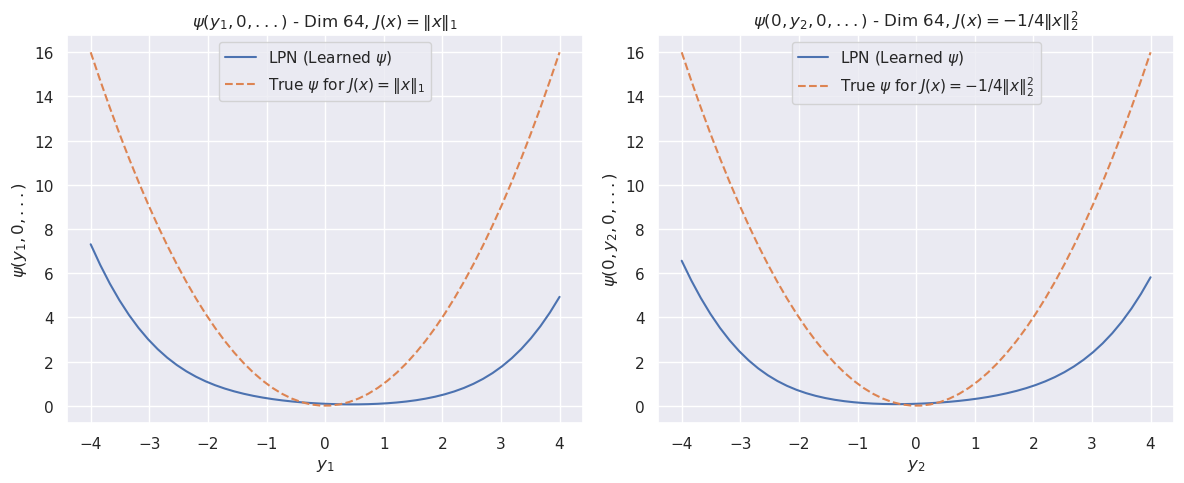

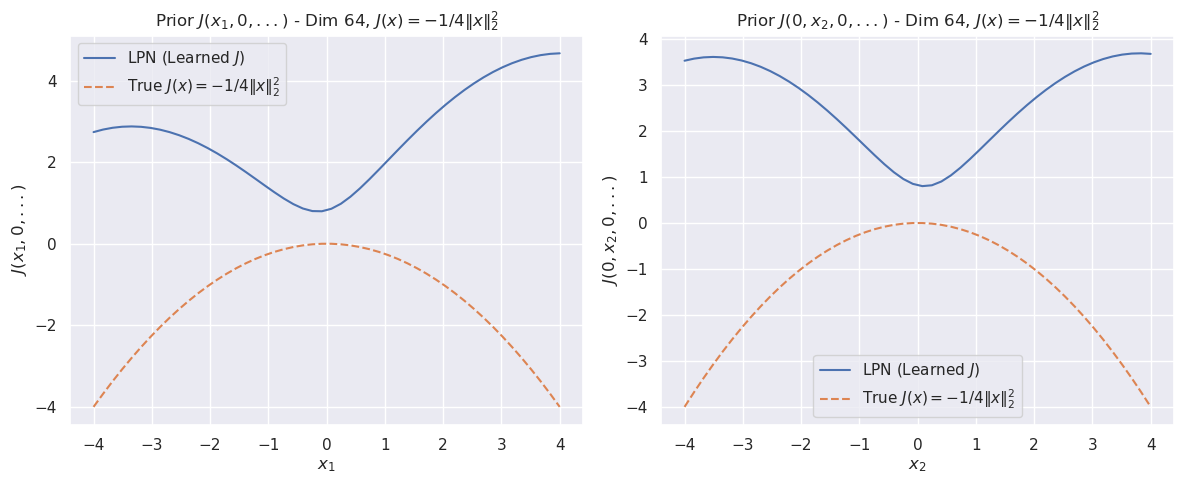

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 71432.8828125
iteration 0 loss 38066.109375


iteration 500 loss 148.57200622558594


iteration 1000 loss 94.94316101074219


iteration 1500 loss 69.47103881835938


iteration 2000 loss 59.149803161621094


iteration 2500 loss 54.4067497253418


iteration 3000 loss 51.071311950683594


iteration 3500 loss 47.885982513427734


iteration 4000 loss 44.660099029541016


iteration 4500 loss 41.443668365478516


iteration 5000 loss 38.28189468383789


iteration 5500 loss 35.200679779052734


iteration 6000 loss 32.22287368774414


iteration 6500 loss 29.332780838012695


iteration 7000 loss 26.542348861694336


iteration 7500 loss 23.910818099975586


iteration 8000 loss 21.448469161987305


iteration 8500 loss 19.151742935180664


iteration 9000 loss 17.03243064880371


iteration 9500 loss 15.10144329071045


iteration 10000 loss 13.387989044189453


iteration 10500 loss 11.874134063720703


iteration 11000 loss 10.614968299865723


iteration 11500 loss 9.511805534362793


iteration 12000 loss 8.721442222595215


iteration 12500 loss 7.938281059265137


iteration 13000 loss 7.236413955688477


iteration 13500 loss 6.7178473472595215


iteration 14000 loss 6.110147953033447


iteration 14500 loss 5.558795928955078


iteration 15000 loss 5.191446781158447


iteration 15500 loss 4.752887725830078


iteration 16000 loss 4.2410149574279785


iteration 16500 loss 3.9881443977355957


iteration 17000 loss 3.7296347618103027


iteration 17500 loss 3.4168639183044434


iteration 18000 loss 3.045966148376465


iteration 18500 loss 2.7880187034606934


iteration 19000 loss 2.6142539978027344


iteration 19500 loss 2.4063572883605957


iteration 20000 loss 2.164146661758423


iteration 20500 loss 1.9509773254394531


iteration 21000 loss 1.8520538806915283


iteration 21500 loss 1.733492136001587


iteration 22000 loss 1.5944035053253174


iteration 22500 loss 1.4368382692337036


iteration 23000 loss 1.3584659099578857


iteration 23500 loss 1.309431791305542


iteration 24000 loss 1.2501378059387207


iteration 24500 loss 1.1793882846832275


iteration 25000 loss 1.096655249595642


iteration 25500 loss 1.0023107528686523


iteration 26000 loss 0.9698977470397949


iteration 26500 loss 0.9326621890068054


iteration 27000 loss 0.8879783153533936


iteration 27500 loss 0.8352925777435303


iteration 28000 loss 0.8915424346923828


iteration 28500 loss 0.7564368844032288


iteration 29000 loss 0.7332754731178284


iteration 29500 loss 0.7051409482955933


iteration 30000 loss 0.6712921261787415


iteration 30500 loss 0.6316734552383423


iteration 31000 loss 0.6119309067726135


iteration 31500 loss 0.5962616801261902


iteration 32000 loss 0.577286422252655


iteration 32500 loss 0.5542657375335693


iteration 33000 loss 0.5268218517303467


iteration 33500 loss 0.5103002190589905


iteration 34000 loss 0.5009301900863647


iteration 34500 loss 0.48993152379989624


iteration 35000 loss 0.4764047861099243


iteration 35500 loss 0.459916889667511


iteration 36000 loss 0.44014638662338257


iteration 36500 loss 0.42765194177627563


iteration 37000 loss 0.42004695534706116


iteration 37500 loss 0.4110637605190277


iteration 38000 loss 0.39999324083328247


iteration 38500 loss 0.3865336775779724


iteration 39000 loss 0.45258593559265137


iteration 39500 loss 0.36582326889038086


iteration 40000 loss 0.3592463731765747


iteration 40500 loss 0.35117974877357483


iteration 41000 loss 0.34125781059265137


iteration 41500 loss 0.3291797339916229


iteration 42000 loss 0.3217126727104187


iteration 42500 loss 0.31629106402397156


iteration 43000 loss 0.3100672960281372


iteration 43500 loss 0.3024006187915802


iteration 44000 loss 0.2930141091346741


iteration 44500 loss 0.2870721220970154


iteration 45000 loss 0.2828277349472046


iteration 45500 loss 0.27856385707855225


iteration 46000 loss 0.2733115553855896


iteration 46500 loss 0.2668049931526184


iteration 47000 loss 0.2589961290359497


iteration 47500 loss 0.255127876996994


iteration 48000 loss 0.2514578700065613


iteration 48500 loss 0.24807877838611603


iteration 49000 loss 0.24396996200084686


iteration 49500 loss 0.23887741565704346


iteration 50000 loss 0.23259638249874115


iteration 50500 loss 0.2298988401889801


iteration 51000 loss 0.22505579888820648


iteration 51500 loss 0.22233635187149048


iteration 52000 loss 0.21918092668056488


iteration 52500 loss 0.215280219912529


iteration 53000 loss 0.21045604348182678


iteration 53500 loss 0.20488914847373962


iteration 54000 loss 0.20359216630458832


iteration 54500 loss 0.20115001499652863


iteration 55000 loss 0.1985253393650055


iteration 55500 loss 0.19530490040779114


iteration 56000 loss 0.19137398898601532


iteration 56500 loss 0.18639029562473297


iteration 57000 loss 0.18442393839359283


iteration 57500 loss 0.18182317912578583


iteration 58000 loss 0.1790146678686142


iteration 58500 loss 0.1755654513835907


iteration 59000 loss 0.17132529616355896


iteration 59500 loss 0.1694575399160385


iteration 60000 loss 0.16715361177921295


iteration 60500 loss 0.1647888571023941


iteration 61000 loss 0.16188842058181763


iteration 61500 loss 0.15832482278347015


iteration 62000 loss 0.1574658900499344


iteration 62500 loss 0.15498954057693481


iteration 63000 loss 0.15335431694984436


iteration 63500 loss 0.15148970484733582


iteration 64000 loss 0.1491907238960266


iteration 64500 loss 0.14653562009334564


iteration 65000 loss 0.14568102359771729


iteration 65500 loss 0.14233815670013428


iteration 66000 loss 0.140533909201622


iteration 66500 loss 0.13842105865478516


iteration 67000 loss 0.1359047293663025


iteration 67500 loss 0.13542655110359192


iteration 68000 loss 0.13311795890331268


iteration 68500 loss 0.13176599144935608


iteration 69000 loss 0.13024930655956268


iteration 69500 loss 0.12840990722179413


iteration 70000 loss 0.12607653439044952


iteration 70500 loss 0.1267722100019455


iteration 71000 loss 0.12369277328252792


iteration 71500 loss 0.12235645204782486


iteration 72000 loss 0.12104285508394241


iteration 72500 loss 0.11947150528430939


iteration 73000 loss 0.11753306537866592


iteration 73500 loss 1.5666568279266357


iteration 74000 loss 0.11496463418006897


iteration 74500 loss 0.11381955444812775


iteration 75000 loss 0.11263617873191833


iteration 75500 loss 0.11119052767753601


iteration 76000 loss 0.1093960553407669


iteration 76500 loss 0.11031951755285263


iteration 77000 loss 0.10757726430892944


iteration 77500 loss 0.10642919689416885


iteration 78000 loss 0.10532807558774948


iteration 78500 loss 0.1040181890130043


iteration 79000 loss 0.102403424680233


iteration 79500 loss 0.1032005101442337


iteration 80000 loss 0.1005907654762268


iteration 80500 loss 0.0994856208562851


iteration 81000 loss 0.09837155789136887


iteration 81500 loss 0.09713683277368546


iteration 82000 loss 0.09537573903799057


iteration 82500 loss 0.09571313112974167


iteration 83000 loss 0.0943683609366417


iteration 83500 loss 0.09345758706331253


iteration 84000 loss 0.09246654063463211


iteration 84500 loss 0.09137561172246933


iteration 85000 loss 0.08981293439865112


iteration 85500 loss 0.08958811312913895


iteration 86000 loss 0.08858012408018112


iteration 86500 loss 0.08773375302553177


iteration 87000 loss 0.08673107624053955


iteration 87500 loss 0.08549002557992935


iteration 88000 loss 0.08611247688531876


iteration 88500 loss 0.08403696119785309


iteration 89000 loss 0.083191879093647


iteration 89500 loss 0.08231789618730545


iteration 90000 loss 0.08125799149274826


iteration 90500 loss 0.07996208220720291


iteration 91000 loss 0.07992110401391983


iteration 91500 loss 0.07894878834486008


iteration 92000 loss 0.07810208946466446


iteration 92500 loss 0.0772712305188179


iteration 93000 loss 0.11434950679540634


iteration 93500 loss 0.07613208144903183


iteration 94000 loss 0.0752590224146843


iteration 94500 loss 0.07451873272657394


iteration 95000 loss 0.07384392619132996


iteration 95500 loss 0.07271011918783188


iteration 96000 loss 0.07310742139816284


iteration 96500 loss 0.07190470397472382


iteration 97000 loss 0.07120690494775772


iteration 97500 loss 0.07050765305757523


iteration 98000 loss 0.06964533776044846


iteration 98500 loss 0.09674948453903198


iteration 99000 loss 0.06899730116128922


iteration 99500 loss 0.06823021918535233


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.06764554232358932


iteration 100500 loss 0.06757665425539017


iteration 101000 loss 0.06749000400304794


iteration 101500 loss 0.0673825815320015


iteration 102000 loss 0.0672464519739151


iteration 102500 loss 0.06707274168729782


iteration 103000 loss 0.06685420870780945


iteration 103500 loss 0.06657733023166656


iteration 104000 loss 0.06622675061225891


iteration 104500 loss 0.0657830685377121


iteration 105000 loss 0.06522198021411896


iteration 105500 loss 0.06451542675495148


iteration 106000 loss 0.06362693756818771


iteration 106500 loss 0.06294552236795425


iteration 107000 loss 0.06260620057582855


iteration 107500 loss 0.06217845901846886


iteration 108000 loss 0.06163571774959564


iteration 108500 loss 0.060949668288230896


iteration 109000 loss 0.06009097769856453


iteration 109500 loss 0.05962870270013809


iteration 110000 loss 0.05931540206074715


iteration 110500 loss 0.05891745910048485


iteration 111000 loss 0.05841189995408058


iteration 111500 loss 0.057774633169174194


iteration 112000 loss 0.05696900561451912


iteration 112500 loss 0.056583501398563385


iteration 113000 loss 0.05633963644504547


iteration 113500 loss 0.05603044852614403


iteration 114000 loss 0.05563769489526749


iteration 114500 loss 0.05513952672481537


iteration 115000 loss 0.054510898888111115


iteration 115500 loss 0.05634753406047821


iteration 116000 loss 0.05349938943982124


iteration 116500 loss 0.05317509546875954


iteration 117000 loss 0.052763864398002625


iteration 117500 loss 0.05224307253956795


iteration 118000 loss 0.05158627778291702


iteration 118500 loss 0.051130034029483795


iteration 119000 loss 0.05089898407459259


iteration 119500 loss 0.05060629919171333


iteration 120000 loss 0.05023423582315445


iteration 120500 loss 0.049762871116399765


iteration 121000 loss 0.04916726425290108


iteration 121500 loss 0.04869084432721138


iteration 122000 loss 0.04850946366786957


iteration 122500 loss 0.04828423634171486


iteration 123000 loss 0.04799784719944


iteration 123500 loss 0.04763377085328102


iteration 124000 loss 0.04717265069484711


iteration 124500 loss 0.04659238085150719


iteration 125000 loss 0.046254437416791916


iteration 125500 loss 0.04607671499252319


iteration 126000 loss 0.04585347697138786


iteration 126500 loss 0.04556954652070999


iteration 127000 loss 0.04520878568291664


iteration 127500 loss 0.04475170746445656


iteration 128000 loss 0.044176965951919556


iteration 128500 loss 0.0439765490591526


iteration 129000 loss 0.04376611113548279


iteration 129500 loss 0.04349905997514725


iteration 130000 loss 0.04316011071205139


iteration 130500 loss 0.04273088648915291


iteration 131000 loss 0.0421903058886528


iteration 131500 loss 0.04199075326323509


iteration 132000 loss 0.04179082065820694


iteration 132500 loss 0.041536662727594376


iteration 133000 loss 0.04121394082903862


iteration 133500 loss 0.04080532118678093


iteration 134000 loss 0.041541703045368195


iteration 134500 loss 0.0402023047208786


iteration 135000 loss 0.040042005479335785


iteration 135500 loss 0.03983786702156067


iteration 136000 loss 0.03957818076014519


iteration 136500 loss 0.03924863040447235


iteration 137000 loss 0.03883228823542595


iteration 137500 loss 0.038508087396621704


iteration 138000 loss 0.038354504853487015


iteration 138500 loss 0.03816186636686325


iteration 139000 loss 0.03791668266057968


iteration 139500 loss 0.03760574012994766


iteration 140000 loss 0.03721090778708458


iteration 140500 loss 0.03691953048110008


iteration 141000 loss 0.03679167106747627


iteration 141500 loss 0.03663793206214905


iteration 142000 loss 0.036441780626773834


iteration 142500 loss 0.03619273006916046


iteration 143000 loss 0.03587689250707626


iteration 143500 loss 0.035478848963975906


iteration 144000 loss 0.03529077023267746


iteration 144500 loss 0.03514036908745766


iteration 145000 loss 0.03495005890727043


iteration 145500 loss 0.034708380699157715


iteration 146000 loss 0.034402016550302505


iteration 146500 loss 0.03401625156402588


iteration 147000 loss 0.03387503698468208


iteration 147500 loss 0.03375760465860367


iteration 148000 loss 0.033610232174396515


iteration 148500 loss 0.033422522246837616


iteration 149000 loss 0.03318384662270546


iteration 149500 loss 0.03288109600543976


iteration 150000 loss 0.032595712691545486


iteration 150500 loss 0.032411206513643265


iteration 151000 loss 0.03225725144147873


iteration 151500 loss 0.03206169232726097


iteration 152000 loss 0.03181346878409386


iteration 152500 loss 0.03150032088160515


iteration 153000 loss 0.03129112347960472


iteration 153500 loss 0.03119318187236786


iteration 154000 loss 0.031073912978172302


iteration 154500 loss 0.030922316014766693


iteration 155000 loss 0.030729157850146294


iteration 155500 loss 0.03048892691731453


iteration 156000 loss 0.03017323464155197


iteration 156500 loss 0.029995573684573174


iteration 157000 loss 0.029881156980991364


iteration 157500 loss 0.029737142845988274


iteration 158000 loss 0.029553808271884918


iteration 158500 loss 0.029322311282157898


iteration 159000 loss 0.029026586562395096


iteration 159500 loss 0.02889990247786045


iteration 160000 loss 0.02880900166928768


iteration 160500 loss 0.028695043176412582


iteration 161000 loss 0.028549954295158386


iteration 161500 loss 0.02836635150015354


iteration 162000 loss 0.02813081629574299


iteration 162500 loss 0.027845392003655434


iteration 163000 loss 0.027736181393265724


iteration 163500 loss 0.0276153776794672


iteration 164000 loss 0.027462318539619446


iteration 164500 loss 0.02726770006120205


iteration 165000 loss 0.027020953595638275


iteration 165500 loss 0.026828844100236893


iteration 166000 loss 0.026745043694972992


iteration 166500 loss 0.02665245346724987


iteration 167000 loss 0.026535170152783394


iteration 167500 loss 0.026385817676782608


iteration 168000 loss 0.026198672130703926


iteration 168500 loss 0.025955015793442726


iteration 169000 loss 0.02578447200357914


iteration 169500 loss 0.025695567950606346


iteration 170000 loss 0.025585761293768883


iteration 170500 loss 0.025445930659770966


iteration 171000 loss 0.0252680666744709


iteration 171500 loss 0.025042824447155


iteration 172000 loss 0.024882495403289795


iteration 172500 loss 0.024810200557112694


iteration 173000 loss 0.024722810834646225


iteration 173500 loss 0.024611830711364746


iteration 174000 loss 0.024470578879117966


iteration 174500 loss 0.024291949346661568


iteration 175000 loss 0.024064436554908752


iteration 175500 loss 0.02394082024693489


iteration 176000 loss 0.02386552281677723


iteration 176500 loss 0.023770904168486595


iteration 177000 loss 0.023650307208299637


iteration 177500 loss 0.02349701151251793


iteration 178000 loss 0.02330245077610016


iteration 178500 loss 0.02312711626291275


iteration 179000 loss 0.02303307130932808


iteration 179500 loss 0.02293417975306511


iteration 180000 loss 0.022808818146586418


iteration 180500 loss 0.022650161758065224


iteration 181000 loss 0.02244744449853897


iteration 181500 loss 0.022356702014803886


iteration 182000 loss 0.022291522473096848


iteration 182500 loss 0.02221142128109932


iteration 183000 loss 0.02210976742208004


iteration 183500 loss 0.02198030613362789


iteration 184000 loss 0.021815499290823936


iteration 184500 loss 0.021607445552945137


iteration 185000 loss 0.021548733115196228


iteration 185500 loss 0.021479060873389244


iteration 186000 loss 0.02139175869524479


iteration 186500 loss 0.021280823275446892


iteration 187000 loss 0.021139705553650856


iteration 187500 loss 0.02096455544233322


iteration 188000 loss 0.020847609266638756


iteration 188500 loss 0.02078954502940178


iteration 189000 loss 0.020723678171634674


iteration 189500 loss 0.020639797672629356


iteration 190000 loss 0.020533304661512375


iteration 190500 loss 0.02039755880832672


iteration 191000 loss 0.020226364955306053


iteration 191500 loss 0.02012861892580986


iteration 192000 loss 0.020072204992175102


iteration 192500 loss 0.020006686449050903


iteration 193000 loss 0.019923392683267593


iteration 193500 loss 0.01981736719608307


iteration 194000 loss 0.019683796912431717


iteration 194500 loss 0.019516000524163246


iteration 195000 loss 0.019445741549134254


iteration 195500 loss 0.019393816590309143


iteration 196000 loss 0.019329607486724854


iteration 196500 loss 0.01924782060086727


iteration 197000 loss 0.019143961369991302


iteration 197500 loss 0.01901273801922798


iteration 198000 loss 0.018844397738575935


iteration 198500 loss 0.01878516562283039


iteration 199000 loss 0.018727200105786324


iteration 199500 loss 0.018653932958841324


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.018560659140348434


iteration 200500 loss 0.018549224361777306


iteration 201000 loss 0.018534446135163307


iteration 201500 loss 0.018514912575483322


iteration 202000 loss 0.018489236012101173


iteration 202500 loss 0.01845642365515232


iteration 203000 loss 0.018415089696645737


iteration 203500 loss 0.01836242340505123


iteration 204000 loss 0.018295064568519592


iteration 204500 loss 0.018209271132946014


iteration 205000 loss 0.018100352957844734


iteration 205500 loss 0.01796291396021843


iteration 206000 loss 0.017835840582847595


iteration 206500 loss 0.017762476578354836


iteration 207000 loss 0.017669206485152245


iteration 207500 loss 0.01755092665553093


iteration 208000 loss 0.017402078956365585


iteration 208500 loss 0.0173140000551939


iteration 209000 loss 0.017221013084053993


iteration 209500 loss 0.01710330694913864


iteration 210000 loss 0.016980409622192383


iteration 210500 loss 0.01689819246530533


iteration 211000 loss 0.0168264452368021


iteration 211500 loss 0.016735417768359184


iteration 212000 loss 0.01662006787955761


iteration 212500 loss 0.0164843387901783


iteration 213000 loss 0.016431650146842003


iteration 213500 loss 0.016367847099900246


iteration 214000 loss 0.016286784783005714


iteration 214500 loss 0.016183996573090553


iteration 215000 loss 0.01605456881225109


iteration 215500 loss 0.015979982912540436


iteration 216000 loss 0.015922538936138153


iteration 216500 loss 0.015849191695451736


iteration 217000 loss 0.015756215900182724


iteration 217500 loss 0.015638768672943115


iteration 218000 loss 0.015545899979770184


iteration 218500 loss 0.015490850433707237


iteration 219000 loss 0.015420690178871155


iteration 219500 loss 0.015331622213125229


iteration 220000 loss 0.015219167806208134


iteration 220500 loss 0.015128365717828274


iteration 221000 loss 0.015080098994076252


iteration 221500 loss 0.01501825824379921


iteration 222000 loss 0.014939757995307446


iteration 222500 loss 0.014840319752693176


iteration 223000 loss 0.014725790359079838


iteration 223500 loss 0.014671679586172104


iteration 224000 loss 0.014602881856262684


iteration 224500 loss 0.014515521004796028


iteration 225000 loss 0.014405233785510063


iteration 225500 loss 0.014330403879284859


iteration 226000 loss 0.01426476426422596


iteration 226500 loss 0.014181448146700859


iteration 227000 loss 0.01407631766051054


iteration 227500 loss 0.014001751318573952


iteration 228000 loss 0.013945668004453182


iteration 228500 loss 0.013874365016818047


iteration 229000 loss 0.01378412451595068


iteration 229500 loss 0.013682624325156212


iteration 230000 loss 0.013632604852318764


iteration 230500 loss 0.013568824157118797


iteration 231000 loss 0.013487749733030796


iteration 231500 loss 0.01338536012917757


iteration 232000 loss 0.013325667940080166


iteration 232500 loss 0.013264046981930733


iteration 233000 loss 0.013185919262468815


iteration 233500 loss 0.013087199069559574


iteration 234000 loss 0.013035934418439865


iteration 234500 loss 0.012989629991352558


iteration 235000 loss 0.012930660508573055


iteration 235500 loss 0.012855648063123226


iteration 236000 loss 0.012760970741510391


iteration 236500 loss 0.01270466297864914


iteration 237000 loss 0.012652507051825523


iteration 237500 loss 0.012586287222802639


iteration 238000 loss 0.01250238437205553


iteration 238500 loss 0.0124279223382473


iteration 239000 loss 0.012394523248076439


iteration 239500 loss 0.012351873330771923


iteration 240000 loss 0.012297243811190128


iteration 240500 loss 0.012227926403284073


iteration 241000 loss 0.012140274047851562


iteration 241500 loss 0.012093944475054741


iteration 242000 loss 0.012058683671057224


iteration 242500 loss 0.012013537809252739


iteration 243000 loss 0.01195594947785139


iteration 243500 loss 0.011882883496582508


iteration 244000 loss 0.011798737570643425


iteration 244500 loss 0.011769634671509266


iteration 245000 loss 0.01173329446464777


iteration 245500 loss 0.011686676181852818


iteration 246000 loss 0.011627424508333206


iteration 246500 loss 0.011552335694432259


iteration 247000 loss 0.011487025767564774


iteration 247500 loss 0.011457397602498531


iteration 248000 loss 0.011419588699936867


iteration 248500 loss 0.011371195316314697


iteration 249000 loss 0.011309761554002762


iteration 249500 loss 0.011231958866119385


iteration 250000 loss 0.011180737987160683


iteration 250500 loss 0.011142754927277565


iteration 251000 loss 0.01109395083039999


iteration 251500 loss 0.011032073758542538


iteration 252000 loss 0.010953881777822971


iteration 252500 loss 0.01091795600950718


iteration 253000 loss 0.01088703703135252


iteration 253500 loss 0.010847536846995354


iteration 254000 loss 0.010797049850225449


iteration 254500 loss 0.010733013972640038


iteration 255000 loss 0.010660328902304173


iteration 255500 loss 0.010631138458848


iteration 256000 loss 0.010593974962830544


iteration 256500 loss 0.010546419769525528


iteration 257000 loss 0.010486075654625893


iteration 257500 loss 0.011013749055564404


iteration 258000 loss 0.010384272783994675


iteration 258500 loss 0.010350947268307209


iteration 259000 loss 0.010308262892067432


iteration 259500 loss 0.010253997519612312


iteration 260000 loss 0.010185345076024532


iteration 260500 loss 0.010147280991077423


iteration 261000 loss 0.010120894759893417


iteration 261500 loss 0.010087250731885433


iteration 262000 loss 0.010044146329164505


iteration 262500 loss 0.009989511221647263


iteration 263000 loss 0.009920372627675533


iteration 263500 loss 0.0098927216604352


iteration 264000 loss 0.009866241365671158


iteration 264500 loss 0.009832547046244144


iteration 265000 loss 0.009789393283426762


iteration 265500 loss 0.009734648279845715


iteration 266000 loss 0.009735815227031708


iteration 266500 loss 0.009637797251343727


iteration 267000 loss 0.00960067380219698


iteration 267500 loss 0.00955337006598711


iteration 268000 loss 0.009493410587310791


iteration 268500 loss 0.009450276382267475


iteration 269000 loss 0.009428179822862148


iteration 269500 loss 0.009400115348398685


iteration 270000 loss 0.009364319033920765


iteration 270500 loss 0.009318685159087181


iteration 271000 loss 0.009260785765945911


iteration 271500 loss 0.009217089973390102


iteration 272000 loss 0.009189915843307972


iteration 272500 loss 0.009155230596661568


iteration 273000 loss 0.009111009538173676


iteration 273500 loss 0.009054915979504585


iteration 274000 loss 0.009013422764837742


iteration 274500 loss 0.008991291746497154


iteration 275000 loss 0.008963240310549736


iteration 275500 loss 0.008927306160330772


iteration 276000 loss 0.008881628513336182


iteration 276500 loss 0.008823716081678867


iteration 277000 loss 0.00879543088376522


iteration 277500 loss 0.008772517554461956


iteration 278000 loss 0.00874341744929552


iteration 278500 loss 0.008706237189471722


iteration 279000 loss 0.00865903589874506


iteration 279500 loss 0.008604324422776699


iteration 280000 loss 0.008585484698414803


iteration 280500 loss 0.008563954383134842


iteration 281000 loss 0.008536546491086483


iteration 281500 loss 0.008501521311700344


iteration 282000 loss 0.008457009680569172


iteration 282500 loss 0.008400673978030682


iteration 283000 loss 0.008380970917642117


iteration 283500 loss 0.008360888808965683


iteration 284000 loss 0.008335511200129986


iteration 284500 loss 0.008303126320242882


iteration 285000 loss 0.008261814713478088


iteration 285500 loss 0.008209475316107273


iteration 286000 loss 0.00817919336259365


iteration 286500 loss 0.008153624832630157


iteration 287000 loss 0.008120924234390259


iteration 287500 loss 0.00807927642017603


iteration 288000 loss 0.008026521652936935


iteration 288500 loss 0.008008129894733429


iteration 289000 loss 0.007989027537405491


iteration 289500 loss 0.007964961230754852


iteration 290000 loss 0.007934215478599072


iteration 290500 loss 0.007894929498434067


iteration 291000 loss 0.007845187559723854


iteration 291500 loss 0.00782153569161892


iteration 292000 loss 0.007804034277796745


iteration 292500 loss 0.007781954016536474


iteration 293000 loss 0.00775389838963747


iteration 293500 loss 0.007718042470514774


iteration 294000 loss 0.007672539912164211


iteration 294500 loss 0.007641687523573637


iteration 295000 loss 0.007624953053891659


iteration 295500 loss 0.0076039195992052555


iteration 296000 loss 0.007577152922749519


iteration 296500 loss 0.007542966865003109


iteration 297000 loss 0.00749969994649291


iteration 297500 loss 0.007465398870408535


iteration 298000 loss 0.0074458965100348


iteration 298500 loss 0.0074211424216628075


iteration 299000 loss 0.0073894537054002285


iteration 299500 loss 0.007349179591983557


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.007311350200325251


iteration 300500 loss 0.00731026753783226


iteration 301000 loss 0.00730880256742239


iteration 301500 loss 0.007306848186999559


iteration 302000 loss 0.007304294966161251


iteration 302500 loss 0.007300982251763344


iteration 303000 loss 0.007296450436115265


iteration 303500 loss 0.007290517445653677


iteration 304000 loss 0.0072828917764127254


iteration 304500 loss 0.007272922899574041


iteration 305000 loss 0.007259983103722334


iteration 305500 loss 0.007243901491165161


iteration 306000 loss 0.0072242566384375095


iteration 306500 loss 0.00720055541023612


iteration 307000 loss 0.007172279059886932


iteration 307500 loss 0.00713928509503603


iteration 308000 loss 0.007102761883288622


iteration 308500 loss 0.007066265679895878


iteration 309000 loss 0.00703003816306591


iteration 309500 loss 0.006994066294282675


iteration 310000 loss 0.00695830537006259


iteration 310500 loss 0.006922833621501923


iteration 311000 loss 0.006887530907988548


iteration 311500 loss 0.006852617487311363


iteration 312000 loss 0.0068178726360201836


iteration 312500 loss 0.006783350836485624


iteration 313000 loss 0.006749070715159178


iteration 313500 loss 0.006715080235153437


iteration 314000 loss 0.006681257393211126


iteration 314500 loss 0.006647618021816015


iteration 315000 loss 0.006614130921661854


iteration 315500 loss 0.006580886896699667


iteration 316000 loss 0.006547778379172087


iteration 316500 loss 0.006514986976981163


iteration 317000 loss 0.0064821974374353886


iteration 317500 loss 0.006449684035032988


iteration 318000 loss 0.0064173429273068905


iteration 318500 loss 0.006385189481079578


iteration 319000 loss 0.006353241391479969


iteration 319500 loss 0.006321415770798922


iteration 320000 loss 0.006289822049438953


iteration 320500 loss 0.006258310284465551


iteration 321000 loss 0.006227065809071064


iteration 321500 loss 0.006195901893079281


iteration 322000 loss 0.0061649540439248085


iteration 322500 loss 0.006134083494544029


iteration 323000 loss 0.0061034769751131535


iteration 323500 loss 0.006072972901165485


iteration 324000 loss 0.006042791530489922


iteration 324500 loss 0.00601256312802434


iteration 325000 loss 0.005982612259685993


iteration 325500 loss 0.005952839273959398


iteration 326000 loss 0.005923199933022261


iteration 326500 loss 0.0058937291614711285


iteration 327000 loss 0.005864373408257961


iteration 327500 loss 0.005835193675011396


iteration 328000 loss 0.00580615596845746


iteration 328500 loss 0.005777326878160238


iteration 329000 loss 0.005748630501329899


iteration 329500 loss 0.005720267537981272


iteration 330000 loss 0.005691845435649157


iteration 330500 loss 0.005663641728460789


iteration 331000 loss 0.005635562818497419


iteration 331500 loss 0.005607602186501026


iteration 332000 loss 0.005579972639679909


iteration 332500 loss 0.005552416201680899


iteration 333000 loss 0.005525023210793734


iteration 333500 loss 0.005497810430824757


iteration 334000 loss 0.0054706730879843235


iteration 334500 loss 0.00544368289411068


iteration 335000 loss 0.005416909698396921


iteration 335500 loss 0.005390174686908722


iteration 336000 loss 0.005363561678677797


iteration 336500 loss 0.005337097216397524


iteration 337000 loss 0.005310817621648312


iteration 337500 loss 0.005284641403704882


iteration 338000 loss 0.005258556921035051


iteration 338500 loss 0.005232568364590406


iteration 339000 loss 0.005206710658967495


iteration 339500 loss 0.005181109998375177


iteration 340000 loss 0.005155543331056833


iteration 340500 loss 0.005130136851221323


iteration 341000 loss 0.005104800220578909


iteration 341500 loss 0.005079625640064478


iteration 342000 loss 0.005054526496678591


iteration 342500 loss 0.005029615480452776


iteration 343000 loss 0.005004772916436195


iteration 343500 loss 0.004980161786079407


iteration 344000 loss 0.004955587442964315


iteration 344500 loss 0.004931207280606031


iteration 345000 loss 0.004906856454908848


iteration 345500 loss 0.004882675129920244


iteration 346000 loss 0.004858523607254028


iteration 346500 loss 0.004834584891796112


iteration 347000 loss 0.0048107849434018135


iteration 347500 loss 0.004787094425410032


iteration 348000 loss 0.004763476550579071


iteration 348500 loss 0.004739994183182716


iteration 349000 loss 0.004716894123703241


iteration 349500 loss 0.004693774506449699


iteration 350000 loss 0.004670719150453806


iteration 350500 loss 0.004647768102586269


iteration 351000 loss 0.004624873399734497


iteration 351500 loss 0.004602188244462013


iteration 352000 loss 0.004579539410769939


iteration 352500 loss 0.004557093605399132


iteration 353000 loss 0.0045347195118665695


iteration 353500 loss 0.004512481857091188


iteration 354000 loss 0.00449032336473465


iteration 354500 loss 0.004468258935958147


iteration 355000 loss 0.004446329083293676


iteration 355500 loss 0.004424537532031536


iteration 356000 loss 0.004402831196784973


iteration 356500 loss 0.004381217993795872


iteration 357000 loss 0.004359720274806023


iteration 357500 loss 0.004338334314525127


iteration 358000 loss 0.004317047074437141


iteration 358500 loss 0.004295901395380497


iteration 359000 loss 0.004274801351130009


iteration 359500 loss 0.004253845661878586


iteration 360000 loss 0.004232980310916901


iteration 360500 loss 0.0042122406885027885


iteration 361000 loss 0.004191591404378414


iteration 361500 loss 0.004171062260866165


iteration 362000 loss 0.004150618799030781


iteration 362500 loss 0.004130219109356403


iteration 363000 loss 0.004109939560294151


iteration 363500 loss 0.004089782480150461


iteration 364000 loss 0.004069728776812553


iteration 364500 loss 0.0040497928857803345


iteration 365000 loss 0.004029945936053991


iteration 365500 loss 0.004010206554085016


iteration 366000 loss 0.003990556579083204


iteration 366500 loss 0.003971019759774208


iteration 367000 loss 0.003951595164835453


iteration 367500 loss 0.003932221792638302


iteration 368000 loss 0.003912972752004862


iteration 368500 loss 0.003893795656040311


iteration 369000 loss 0.0038748146034777164


iteration 369500 loss 0.003855853108689189


iteration 370000 loss 0.0038370222318917513


iteration 370500 loss 0.003818263066932559


iteration 371000 loss 0.003799615427851677


iteration 371500 loss 0.0037810965441167355


iteration 372000 loss 0.0037626021075993776


iteration 372500 loss 0.003744252258911729


iteration 373000 loss 0.0037259687669575214


iteration 373500 loss 0.0037078047171235085


iteration 374000 loss 0.0036897193640470505


iteration 374500 loss 0.0036717611365020275


iteration 375000 loss 0.00365385040640831


iteration 375500 loss 0.003636054927483201


iteration 376000 loss 0.0036183553747832775


iteration 376500 loss 0.0036007133312523365


iteration 377000 loss 0.003583183279260993


iteration 377500 loss 0.003565716091543436


iteration 378000 loss 0.0035483373794704676


iteration 378500 loss 0.0035310378298163414


iteration 379000 loss 0.0035138551611453295


iteration 379500 loss 0.0034967714454978704


iteration 380000 loss 0.00347979087382555


iteration 380500 loss 0.0034628496505320072


iteration 381000 loss 0.003446006216108799


iteration 381500 loss 0.0034292731434106827


iteration 382000 loss 0.0034126562532037497


iteration 382500 loss 0.003396060084924102


iteration 383000 loss 0.003379576839506626


iteration 383500 loss 0.0033631674014031887


iteration 384000 loss 0.0033468161709606647


iteration 384500 loss 0.0033306151162832975


iteration 385000 loss 0.0033144576009362936


iteration 385500 loss 0.003298411378636956


iteration 386000 loss 0.003282442456111312


iteration 386500 loss 0.0032665194012224674


iteration 387000 loss 0.0032507150899618864


iteration 387500 loss 0.0032349624671041965


iteration 388000 loss 0.0032193129882216454


iteration 388500 loss 0.0032037878409028053


iteration 389000 loss 0.0031882724724709988


iteration 389500 loss 0.003172849537804723


iteration 390000 loss 0.003157477593049407


iteration 390500 loss 0.003142257686704397


iteration 391000 loss 0.0031270640902221203


iteration 391500 loss 0.0031119701452553272


iteration 392000 loss 0.0030971518717706203


iteration 392500 loss 0.003082182025536895


iteration 393000 loss 0.0030672885477542877


iteration 393500 loss 0.0030524879693984985


iteration 394000 loss 0.0030378017108887434


iteration 394500 loss 0.00302322069182992


iteration 395000 loss 0.0030086494516581297


iteration 395500 loss 0.0029941569082438946


iteration 396000 loss 0.0029797623865306377


iteration 396500 loss 0.0029654609970748425


iteration 397000 loss 0.0029512308537960052


iteration 397500 loss 0.0029370742850005627


iteration 398000 loss 0.002922970103099942


iteration 398500 loss 0.0029089231975376606


iteration 399000 loss 0.0028949808329343796


iteration 399500 loss 0.002881147200241685


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0028674087952822447


iteration 400500 loss 0.0028660777024924755


iteration 401000 loss 0.0028645836282521486


iteration 401500 loss 0.0028628120198845863


iteration 402000 loss 0.002860691398382187


iteration 402500 loss 0.002858345629647374


iteration 403000 loss 0.0028557416517287493


iteration 403500 loss 0.002852907171472907


iteration 404000 loss 0.0028499008622020483


iteration 404500 loss 0.0028467935044318438


iteration 405000 loss 0.002843571826815605


iteration 405500 loss 0.002840306144207716


iteration 406000 loss 0.0028370546642690897


iteration 406500 loss 0.002833809470757842


iteration 407000 loss 0.0028305761516094208


iteration 407500 loss 0.0028273575007915497


iteration 408000 loss 0.0028241921681910753


iteration 408500 loss 0.002821026835590601


iteration 409000 loss 0.0028178568463772535


iteration 409500 loss 0.002814722713083029


iteration 410000 loss 0.0028115976601839066


iteration 410500 loss 0.00280847679823637


iteration 411000 loss 0.0028053903952240944


iteration 411500 loss 0.0028023093473166227


iteration 412000 loss 0.002799209440127015


iteration 412500 loss 0.002796161687001586


iteration 413000 loss 0.002793123247101903


iteration 413500 loss 0.0027900966815650463


iteration 414000 loss 0.0027870445046573877


iteration 414500 loss 0.0027840384282171726


iteration 415000 loss 0.0027810302563011646


iteration 415500 loss 0.002778022550046444


iteration 416000 loss 0.002775071654468775


iteration 416500 loss 0.0027721149381250143


iteration 417000 loss 0.002769127255305648


iteration 417500 loss 0.0027661689091473818


iteration 418000 loss 0.002763239201158285


iteration 418500 loss 0.002760286210104823


iteration 419000 loss 0.0027574028354138136


iteration 419500 loss 0.002754461020231247


iteration 420000 loss 0.0027515648398548365


iteration 420500 loss 0.0027486940380185843


iteration 421000 loss 0.00274579506367445


iteration 421500 loss 0.002742912620306015


iteration 422000 loss 0.0027400427497923374


iteration 422500 loss 0.002737185684964061


iteration 423000 loss 0.002734332112595439


iteration 423500 loss 0.002731482731178403


iteration 424000 loss 0.0027286349795758724


iteration 424500 loss 0.002725813305005431


iteration 425000 loss 0.002722972771152854


iteration 425500 loss 0.002720144111663103


iteration 426000 loss 0.002717328257858753


iteration 426500 loss 0.0027144905179739


iteration 427000 loss 0.0027117084246128798


iteration 427500 loss 0.002708921441808343


iteration 428000 loss 0.00270611303858459


iteration 428500 loss 0.002703316742554307


iteration 429000 loss 0.0027005213778465986


iteration 429500 loss 0.0026977630332112312


iteration 430000 loss 0.0026949928142130375


iteration 430500 loss 0.002692215610295534


iteration 431000 loss 0.0026894432958215475


iteration 431500 loss 0.0026866858825087547


iteration 432000 loss 0.0026839133352041245


iteration 432500 loss 0.002681163139641285


iteration 433000 loss 0.002678411779925227


iteration 433500 loss 0.0026756590232253075


iteration 434000 loss 0.002672929782420397


iteration 434500 loss 0.002670198678970337


iteration 435000 loss 0.0026674841064959764


iteration 435500 loss 0.0026647576596587896


iteration 436000 loss 0.002662008861079812


iteration 436500 loss 0.002659308025613427


iteration 437000 loss 0.002656585769727826


iteration 437500 loss 0.0026538849342614412


iteration 438000 loss 0.002651176182553172


iteration 438500 loss 0.002648490946739912


iteration 439000 loss 0.002645787550136447


iteration 439500 loss 0.002643067389726639


iteration 440000 loss 0.002640390070155263


iteration 440500 loss 0.002637704135850072


iteration 441000 loss 0.0026350223924964666


iteration 441500 loss 0.0026323474012315273


iteration 442000 loss 0.0026296519208699465


iteration 442500 loss 0.0026269995141774416


iteration 443000 loss 0.0026243345346301794


iteration 443500 loss 0.002621660241857171


iteration 444000 loss 0.0026190055068582296


iteration 444500 loss 0.0026163654401898384


iteration 445000 loss 0.0026136834640055895


iteration 445500 loss 0.0026110371109098196


iteration 446000 loss 0.0026084096170961857


iteration 446500 loss 0.00260575907304883


iteration 447000 loss 0.0026031092274934053


iteration 447500 loss 0.0026004810351878405


iteration 448000 loss 0.00259785121306777


iteration 448500 loss 0.0025952202267944813


iteration 449000 loss 0.002592590171843767


iteration 449500 loss 0.002589987823739648


iteration 450000 loss 0.002587366383522749


iteration 450500 loss 0.0025847507640719414


iteration 451000 loss 0.002582134213298559


iteration 451500 loss 0.002579501597210765


iteration 452000 loss 0.0025769199710339308


iteration 452500 loss 0.002574322046712041


iteration 453000 loss 0.002571728080511093


iteration 453500 loss 0.002569125732406974


iteration 454000 loss 0.0025665555149316788


iteration 454500 loss 0.0025639599189162254


iteration 455000 loss 0.002561368979513645


iteration 455500 loss 0.002558779437094927


iteration 456000 loss 0.002556201070547104


iteration 456500 loss 0.002553628059104085


iteration 457000 loss 0.0025510455016046762


iteration 457500 loss 0.002548482734709978


iteration 458000 loss 0.002545913914218545


iteration 458500 loss 0.0025433655828237534


iteration 459000 loss 0.002540776040405035


iteration 459500 loss 0.002538236090913415


iteration 460000 loss 0.00253567798063159


iteration 460500 loss 0.0025331133510917425


iteration 461000 loss 0.0025305503513664007


iteration 461500 loss 0.002528018783777952


iteration 462000 loss 0.0025254751089960337


iteration 462500 loss 0.0025229414459317923


iteration 463000 loss 0.0025203879922628403


iteration 463500 loss 0.0025178485084325075


iteration 464000 loss 0.0025153234601020813


iteration 464500 loss 0.0025127928238362074


iteration 465000 loss 0.002510267775505781


iteration 465500 loss 0.0025077457539737225


iteration 466000 loss 0.0025052207056432962


iteration 466500 loss 0.002502703107893467


iteration 467000 loss 0.002500200178474188


iteration 467500 loss 0.0024976846762001514


iteration 468000 loss 0.0024951817467808723


iteration 468500 loss 0.002492662286385894


iteration 469000 loss 0.002490156562998891


iteration 469500 loss 0.002487654099240899


iteration 470000 loss 0.002485148375853896


iteration 470500 loss 0.002482654992491007


iteration 471000 loss 0.002480163238942623


iteration 471500 loss 0.002477675676345825


iteration 472000 loss 0.0024751871824264526


iteration 472500 loss 0.0024726963602006435


iteration 473000 loss 0.0024702143855392933


iteration 473500 loss 0.002467745915055275


iteration 474000 loss 0.002465218771249056


iteration 474500 loss 0.0024627617094665766


iteration 475000 loss 0.0024603207129985094


iteration 475500 loss 0.002457832684740424


iteration 476000 loss 0.002455351408571005


iteration 476500 loss 0.002452883403748274


iteration 477000 loss 0.002450416563078761


iteration 477500 loss 0.002447945298627019


iteration 478000 loss 0.0024454898666590452


iteration 478500 loss 0.002443033969029784


iteration 479000 loss 0.002440572017803788


iteration 479500 loss 0.0024381258990615606


iteration 480000 loss 0.00243568466976285


iteration 480500 loss 0.002433227375149727


iteration 481000 loss 0.002430770779028535


iteration 481500 loss 0.0024283411912620068


iteration 482000 loss 0.00242589577101171


iteration 482500 loss 0.002423462923616171


iteration 483000 loss 0.002421016339212656


iteration 483500 loss 0.0024185904767364264


iteration 484000 loss 0.0024161606561392546


iteration 484500 loss 0.002413730835542083


iteration 485000 loss 0.002411301713436842


iteration 485500 loss 0.002408872125670314


iteration 486000 loss 0.0024064669851213694


iteration 486500 loss 0.002404047641903162


iteration 487000 loss 0.002401634817942977


iteration 487500 loss 0.002399215241894126


iteration 488000 loss 0.002396811731159687


iteration 488500 loss 0.002394390292465687


iteration 489000 loss 0.002391983289271593


iteration 489500 loss 0.002389564411714673


iteration 490000 loss 0.002387187909334898


iteration 490500 loss 0.002384746912866831


iteration 491000 loss 0.0023823780938982964


iteration 491500 loss 0.002379975514486432


iteration 492000 loss 0.0023775866720825434


iteration 492500 loss 0.002375192940235138


iteration 493000 loss 0.002372832503169775


iteration 493500 loss 0.0023704292252659798


iteration 494000 loss 0.0023680415470153093


iteration 494500 loss 0.0023656687699258327


iteration 495000 loss 0.002363278064876795


iteration 495500 loss 0.0023609139025211334


iteration 496000 loss 0.002358534839004278


iteration 496500 loss 0.0023561834823340178


iteration 497000 loss 0.0023537948727607727


iteration 497500 loss 0.0023514225613325834


iteration 498000 loss 0.0023490870371460915


iteration 498500 loss 0.002346708904951811


iteration 499000 loss 0.002344375941902399


iteration 499500 loss 0.002341996179893613


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


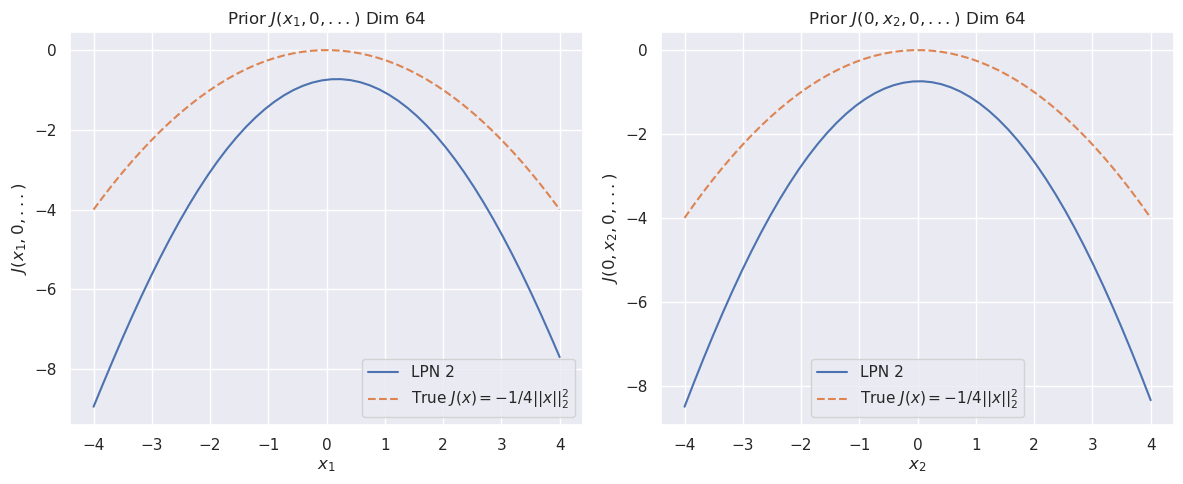

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)